<a href="https://colab.research.google.com/github/Mmengyw/Capstone-Updated/blob/main/Depth%20Prediction/DepthPrediction_to_PointCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
import torch
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
#test


2.7.0


In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 8.3 MB/s 


In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!git clone https://github.com/Mmengyw/Capstone-Updated.git
!ls
os.chdir("Capstone-Updated/Videos")

Cloning into 'Capstone-Updated'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 88 (delta 35), reused 14 (delta 5), pack-reused 18
Unpacking objects: 100% (88/88), done.
Capstone-Updated  sample_data


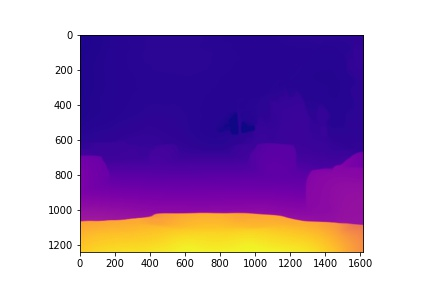

In [ ]:
!ls
def depth_prediction_stream(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    plt.imshow(output, cmap='plasma')
    # # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()

def depth_prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream(original_im, frame, index)


SAMPLE_VIDEO = 'test12.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 60

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

In [ ]:
frames = []
def depth_prediction_stream_2(image, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    plt.imshow(output)

    plt.savefig('saved_figure.jpg')
    im = cv.imread('saved_figure.jpg')
    frames.append(im)
    plt.close()

def depth_prediction_video_2(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    depth_prediction_stream_2(original_im, frame, index)


In [ ]:
video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 100  # uncomment to use the full sample video
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        depth_prediction_video_2(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('DepthPrediction.avi', fourcc, 20.0, size)
 
for i in range(len(frames)):
    out.write(frames[i])
out.release()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
img = frame
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
  prediction = midas(input_batch)

  prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(1),
    size=img.shape[:2],
    mode="bicubic",
    align_corners=False,
  ).squeeze()

output = prediction.cpu().numpy()
output=(50*output/np.max(output))
fig = plt.figure(figsize=(16,12))
plt.imshow(output,cmap='plasma')

# plt.imshow(frame, cmap='plasma')

NameError: ignored

50.459732


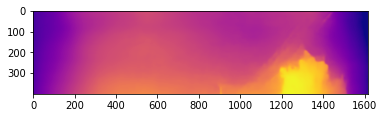

In [ ]:
# print(output[0:400])
plt.imshow(output[0:400,:],cmap='plasma')
print(np.max(output))

50.459732


(array([1.04450e+05, 3.34979e+05, 3.15159e+05, 2.20574e+05, 7.14090e+04,
        4.44140e+04, 3.82780e+04, 4.01670e+04, 4.45470e+04, 3.32820e+04,
        4.68900e+04, 6.72310e+04, 7.61540e+04, 8.61960e+04, 6.39000e+04,
        5.30660e+04, 3.52900e+04, 5.22900e+03, 8.00000e+02, 7.11000e+02,
        6.73000e+02, 5.08000e+02, 5.13000e+02, 5.30000e+02, 4.51000e+02,
        4.29000e+02, 4.01000e+02, 4.62000e+02, 6.37000e+02, 6.34000e+02,
        6.17000e+02, 5.21000e+02, 3.78000e+02, 2.96000e+02, 3.22000e+02,
        3.17000e+02, 3.29000e+02, 4.59000e+02, 5.61000e+02, 9.06000e+02,
        2.00300e+03, 6.18900e+03, 9.72700e+03, 4.05730e+04, 6.98910e+04,
        5.02750e+04, 4.05880e+04, 4.30900e+04, 3.42550e+04, 1.45790e+04]),
 array([-6.2641366e-03,  1.0030558e+00,  2.0123756e+00,  3.0216956e+00,
         4.0310154e+00,  5.0403357e+00,  6.0496554e+00,  7.0589752e+00,
         8.0682955e+00,  9.0776148e+00,  1.0086935e+01,  1.1096255e+01,
         1.2105575e+01,  1.3114895e+01,  1.4124215e+

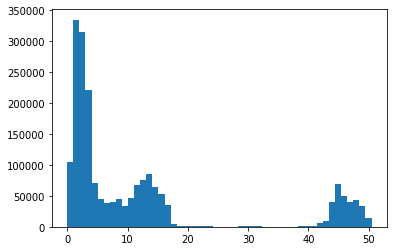

In [ ]:
flat_out = output.flatten()
print(np.max(flat_out))
plt.hist(flat_out, bins = 50)

In [ ]:
import math

def depth2pcd(depth):
    width = depth.shape[1]
    height = depth.shape[0]
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []

    for v in range(0, width, 5):
        for u in range(0, height, 5):
            Z = depth[u][v]
            if Z == 0:
                continue
            X_cam = (v - cx)
            Y_cam = -(u - cy)
            X = X_cam/fx*Z
            Y = Y_cam/fy*Z

            points.append([X, Y, Z])
            
    return np.array(points)

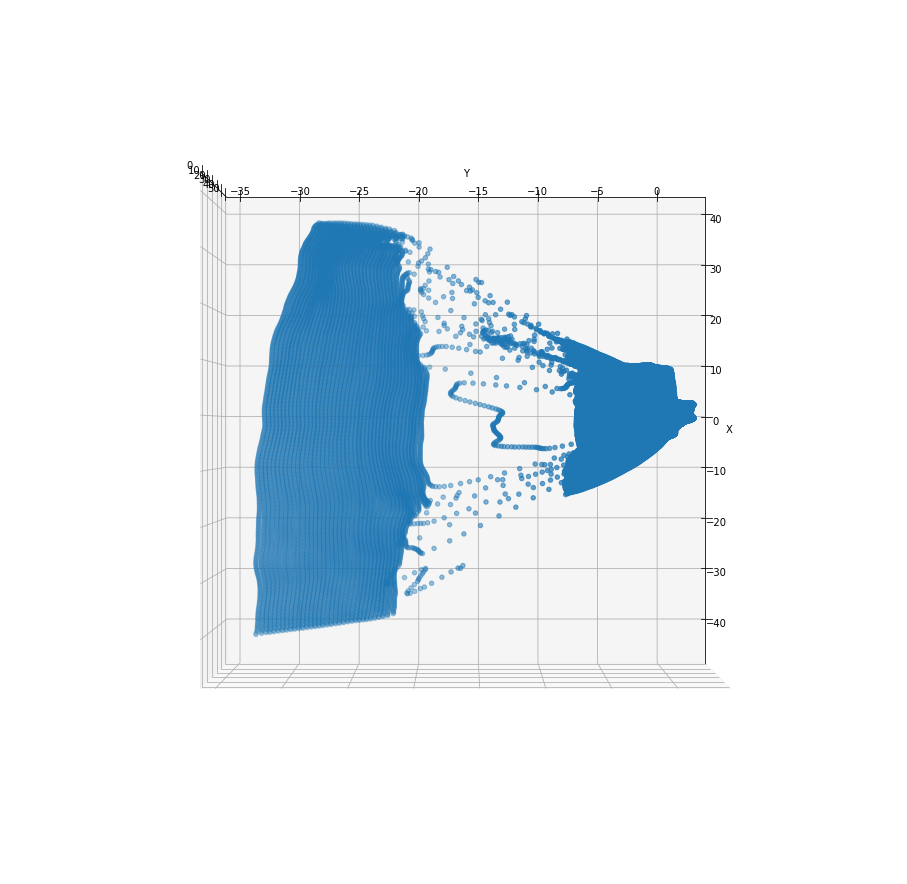

In [ ]:
pc_3d = depth2pcd(output)
# print(pc_3d)


x = pc_3d[:, 0]
y = pc_3d[:, 1]
z = pc_3d[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(270,0)
ax.scatter(x,y,z)
plt.xlabel('X')
plt.ylabel('Y')
# plt.zlabel('Z')
plt.show()


In [ ]:
fig = plt.figure(figsize=(5,8))
plt.scatter(z,x)
plt.xlabel('Z')
plt.ylabel('X')

NameError: ignored

In [ ]:
fx= 926.9796142578125
fy= 924.431884765625
cx= 790.234375
cy= 617.5499267578125
Ai = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
Intrinsic = np.linalg.inv(Ai)
print(Intrinsic)

[[ 0.00107877  0.         -0.85248301]
 [ 0.          0.00108175 -0.66803183]
 [ 0.          0.          1.        ]]


In [ ]:
def depth2pcd2(depth,A):
    width = depth.shape[1]
    height = depth.shape[0]
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []

    for v in range(0, width, 5):
        for u in range(0, height, 5):
            Z = depth[u][v]
            if Z == 0:
                continue
            X_cam = (v - cx)
            Y_cam = -(u - cy)
            point = A@[X_cam,Y_cam,fx]

            points.append([point[0],point[1],point[2]])
            
    return np.array(points)

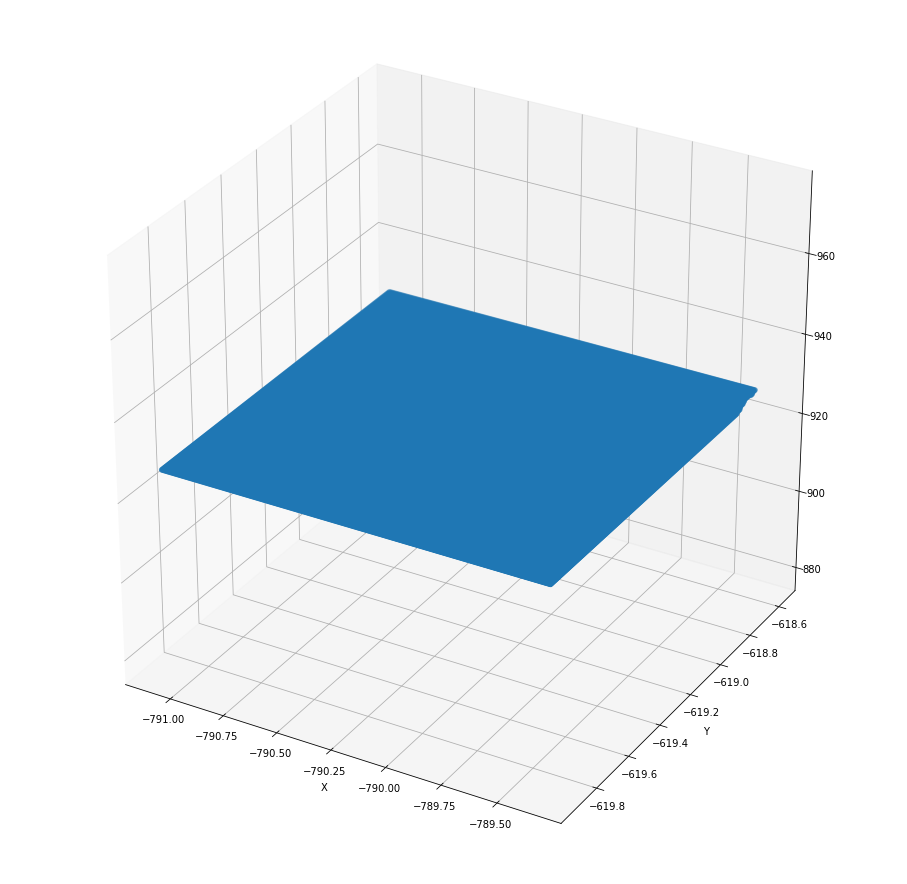

In [ ]:
pc_3d = depth2pcd2(output,Intrinsic)
# print(pc_3d)


x = pc_3d[:, 0]
y = pc_3d[:, 1]
z = pc_3d[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# ax.view_init(270,0)
ax.scatter(x,y,z)
plt.xlabel('X')
plt.ylabel('Y')
# plt.zlabel('Z')
plt.show()
